# 时间序列分析第七次作业

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、数据导入
AKShare借口调取 2016-01-01 到 2021-01-01 茅台股票（东方财富）数据并且仅保留股票收盘价这个序列

              日期    股票代码        开盘        收盘        最高        最低    成交量  \
0     2016-01-04  600519   1204.89   1164.79   1204.89   1164.64  17350   
1     2016-01-05  600519   1164.69   1178.86   1184.64   1152.18  31909   
2     2016-01-06  600519   1178.66   1175.65   1183.08   1161.17  23761   
3     2016-01-07  600519   1159.62   1125.65   1159.62   1114.59   8149   
4     2016-01-08  600519   1135.40   1137.71   1154.64   1114.44  44510   
...          ...     ...       ...       ...       ...       ...    ...   
1213  2020-12-25  600519   9448.12   9583.84   9669.26   9433.09  23088   
1214  2020-12-28  600519   9566.75   9799.90   9879.29   9563.99  30080   
1215  2020-12-29  600519   9799.90   9769.75   9869.24   9709.46  22868   
1216  2020-12-30  600519   9784.83  10101.39  10101.39   9784.78  34452   
1217  2020-12-31  600519  10141.59  10428.00  10432.93  10131.54  38860   

               成交额    振幅   涨跌幅     涨跌额   换手率  
0     3.719098e+08  3.34 -3.40  -41.05  0.14  
1    

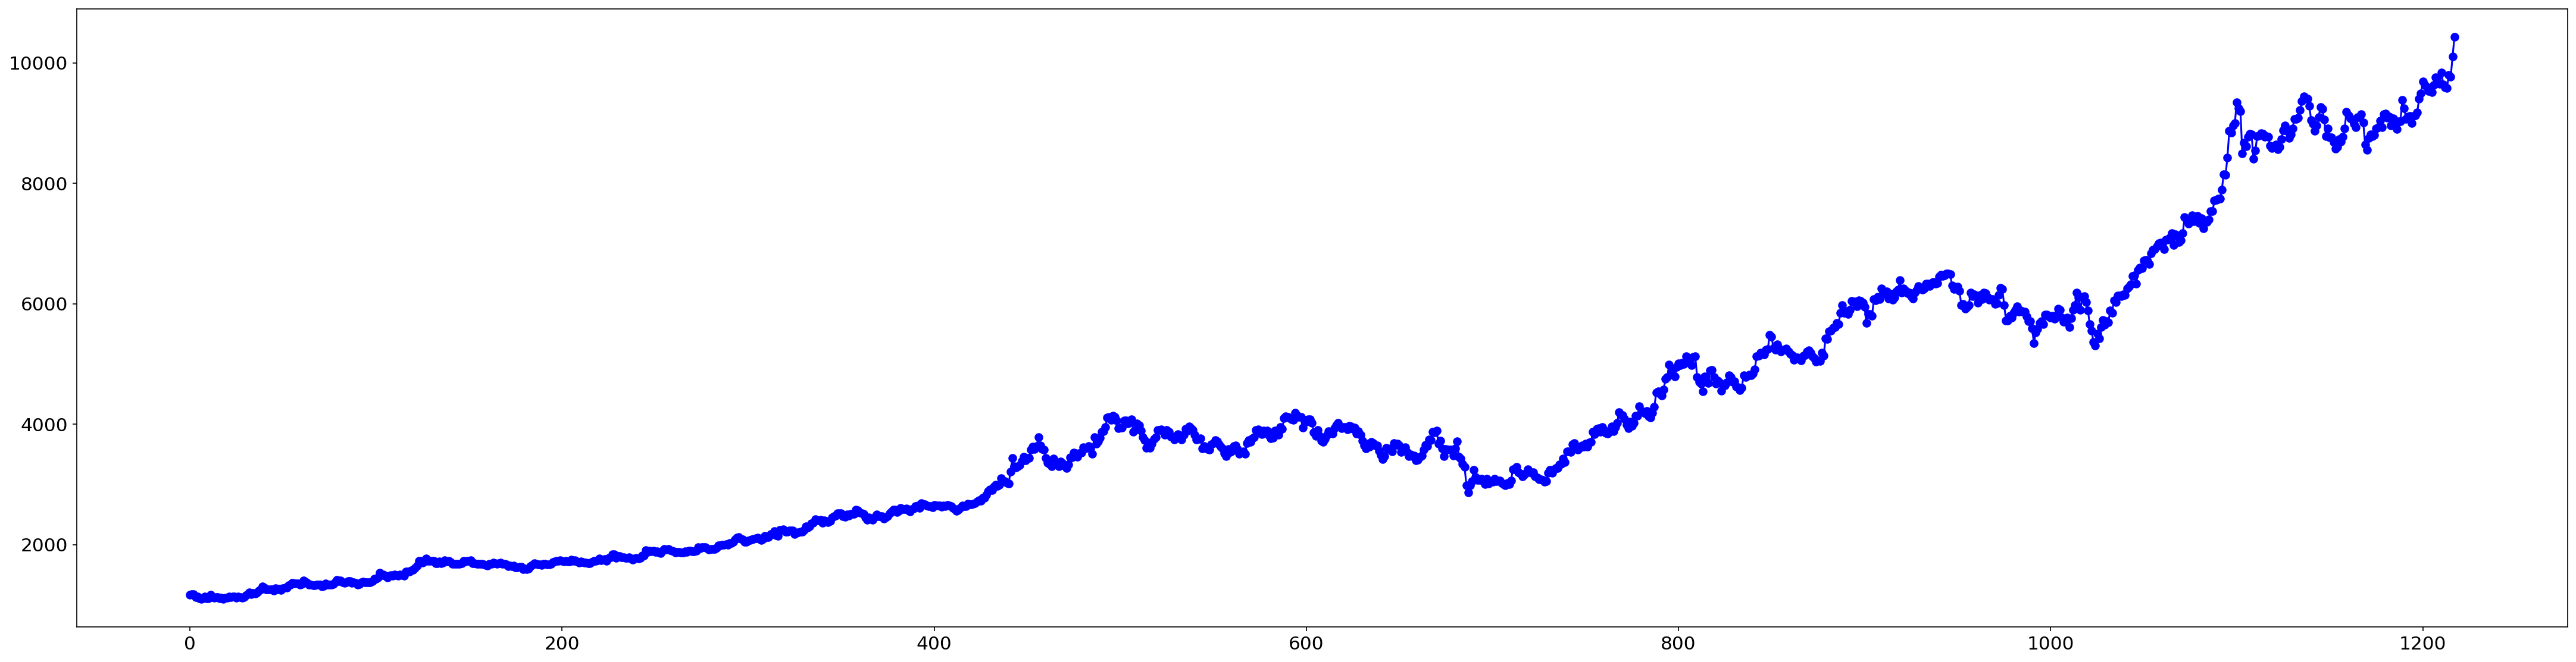

In [2]:
import akshare as ak
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import pandas as pd
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_lm
from arch.univariate import arch_model
import scipy.stats as st
from scipy.stats import jarque_bera

## 数据导入
# AKShare借口调取 2016-01-01 到 2021-01-01 茅台股票（东方财富）数据
stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol="600519", period="daily", start_date="20160101", end_date='20210101', adjust="hfq")
print(stock_zh_a_hist_df)

# 仅保留股票收盘价这个序列
price = stock_zh_a_hist_df.iloc[:, 3]
print(f'茅台股票收盘价：{price}')

# 绘制序列图做平稳性检验
plt.figure(figsize=(36, 9), dpi=150)
plt.plot(price, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='茅台股票收盘价序列图.png')

## 二、数据变换变换与平稳性检验
### 2.1 对数变换与开根号变换
数量量级太大了，来个对数变换+开根号让数据量级小一点，方便研究

均值：2.854474884157809，方差：0.010630821421657855


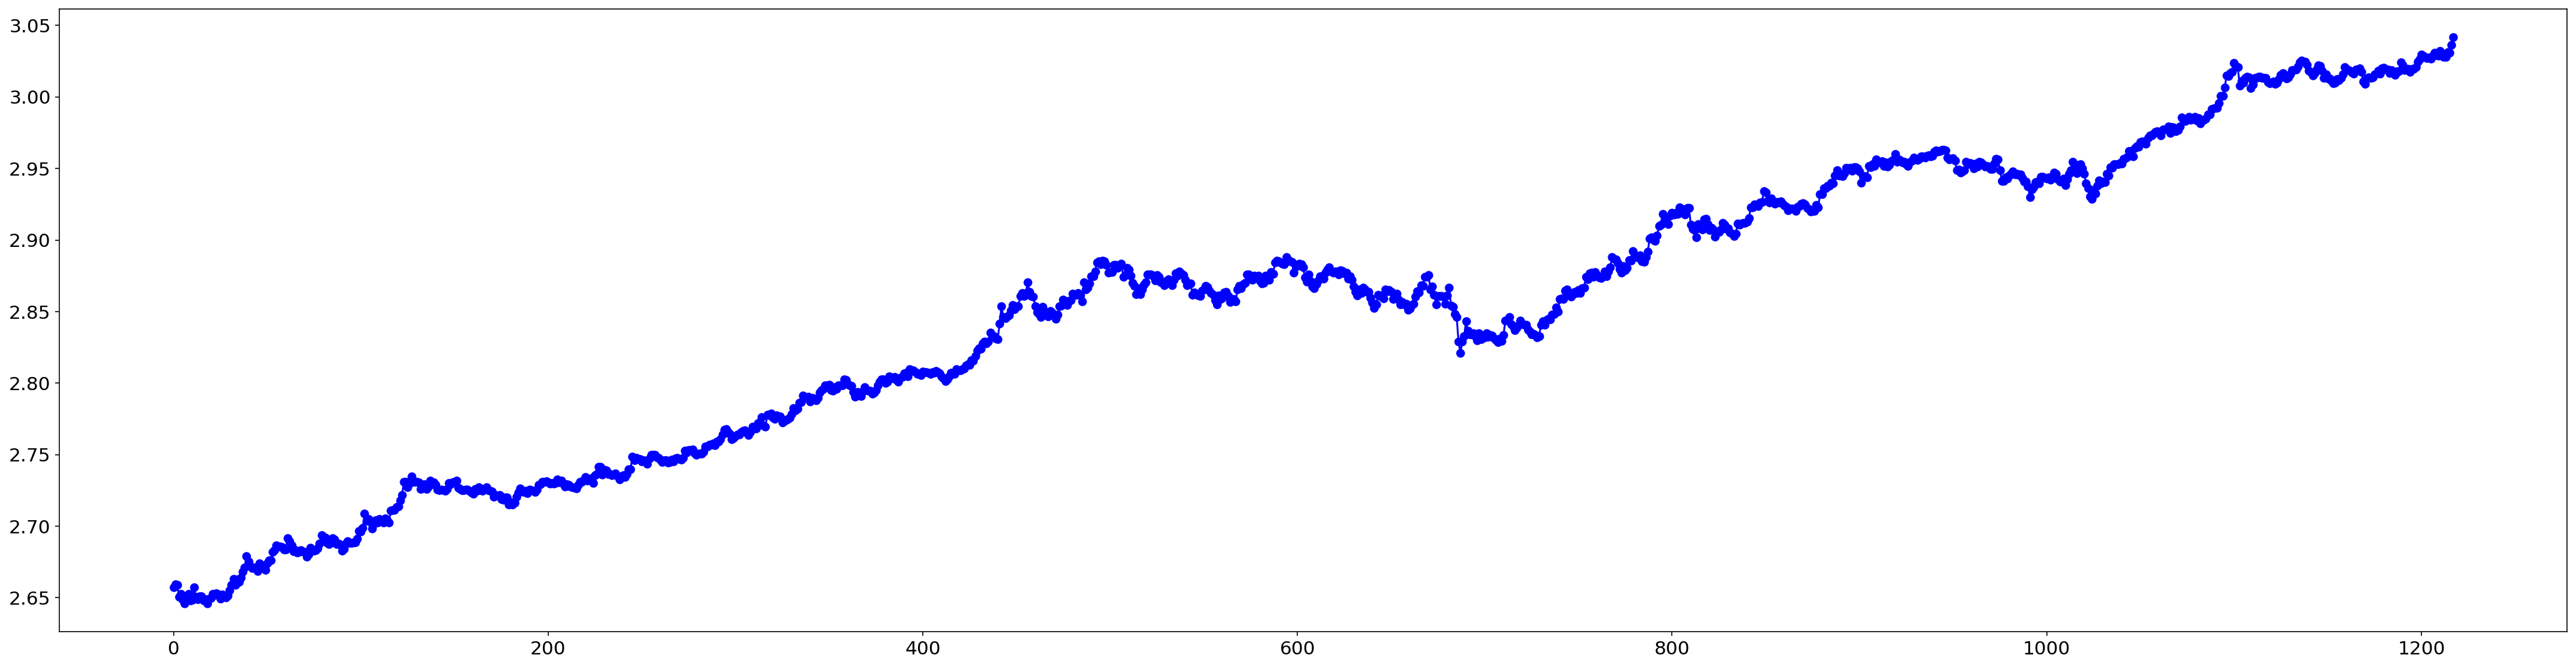

In [3]:
## 数据变换与平稳性检验
# 对数变换 + 根号变换
data = np.sqrt(np.log(price))

# 计算均值和方差
mean = np.mean(data)
variance = np.var(data)
print(f'均值：{mean}，方差：{variance}')

# 绘制序列图做平稳性检验
plt.figure(figsize=(36, 9), dpi=150)
plt.plot(data, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='变换后的序列图.png')

### 2.2 ADF检验
原假设$$H0:序列非平稳$$
备择假设$$H1:序列平稳$$

In [4]:
# 数据做 ADF 检验
result_ADF = adfuller(data , autolag='AIC')
print(f' ADF 检验统计量：{result_ADF[0]}')
print(f'p 值：{result_ADF[1]}')
print(f'临界值（1%）：{result_ADF[4]["1%"]}')
print(f'临界值（5%）：{result_ADF[4]["5%"]}')
print(f'临界值（10%）：{result_ADF[4]["10%"]}')

if result_ADF[1] < 0.05:
    print('ADF检验下数据是平稳的。')
else:
    print('ADF检验下数据不是平稳的。')

 ADF 检验统计量：-0.6969165306506089
p 值：0.8475466100660269
临界值（1%）：-3.4357346726088136
临界值（5%）：-2.863917819294165
临界值（10%）：-2.568035988607032
ADF检验下数据不是平稳的。


### 2.3 PP检验
原假设$$H0:时间序列包含单位根$$
备择假设$$H1:时间序列为弱平稳$$

In [5]:
# 数据做 PP 检验
pp = PhillipsPerron(data)
print(pp.summary().as_text())

p_value = pp.pvalue

if p_value < 0.05:
    print("拒绝原假设，PP检验下数据是平稳数据。")
else:
    print("不拒绝原假设，PP检验下数据是非平稳数据。")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.667
P-value                         0.855
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
不拒绝原假设，PP检验下数据是非平稳数据。


## 三、数据差分与平稳性检验
### 3.1 一阶差分

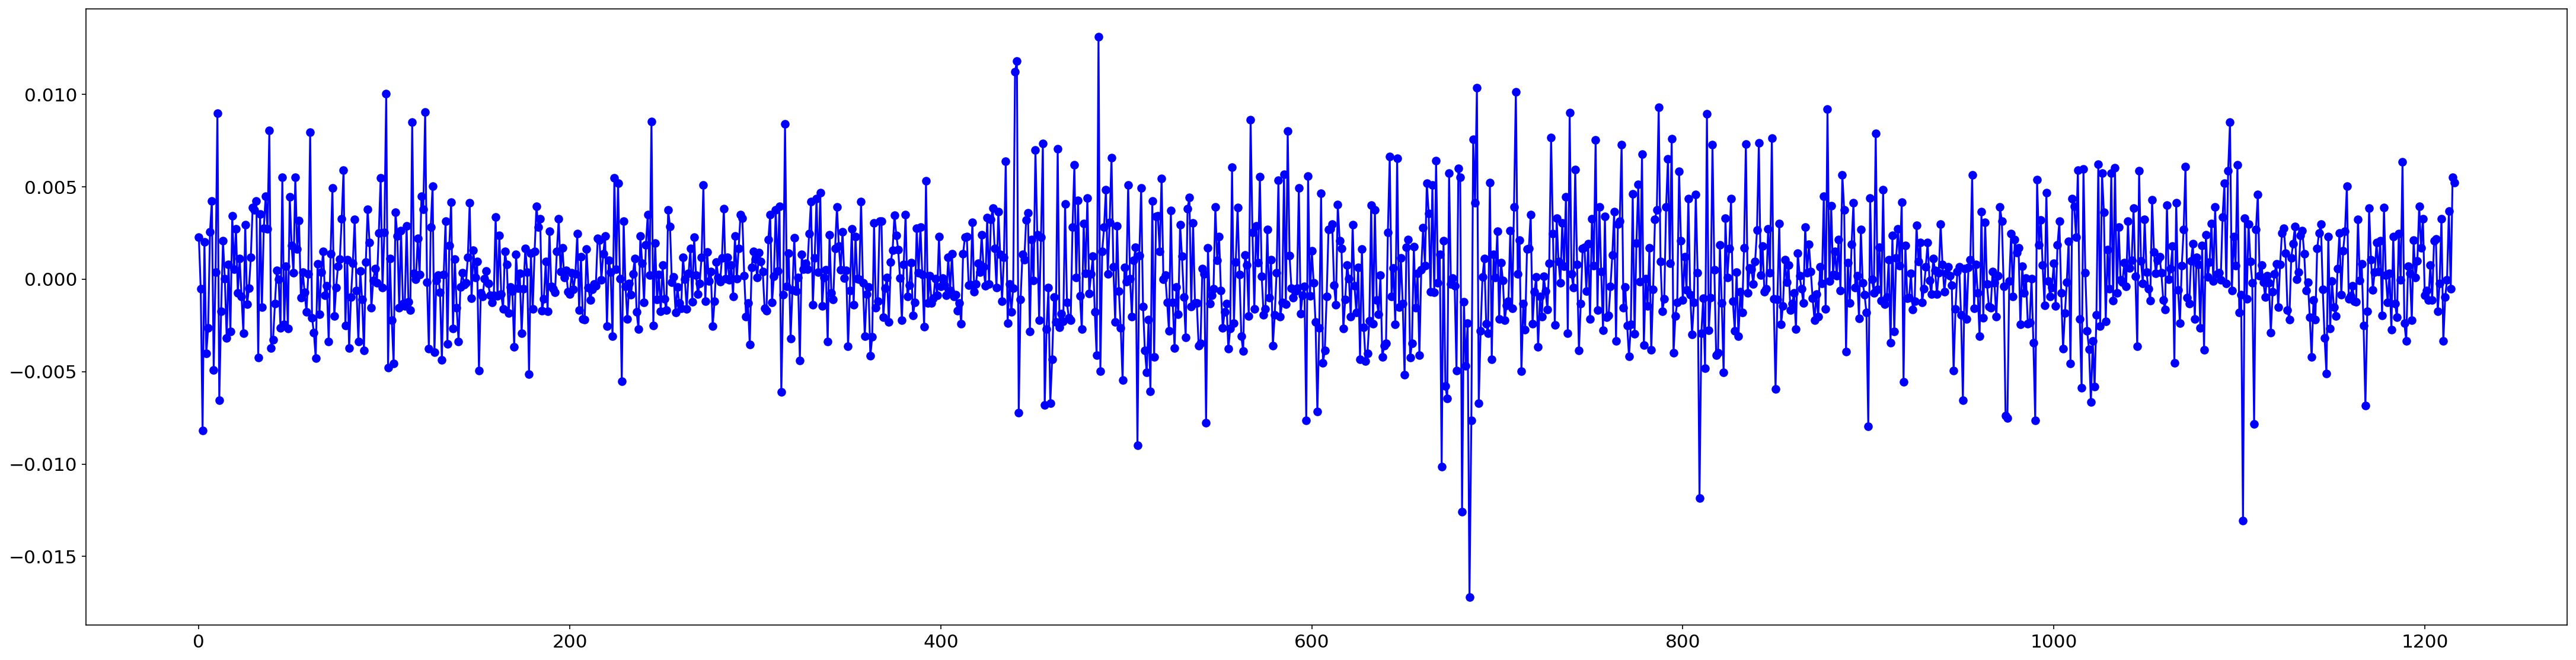

In [6]:
## 数据差分
# 一阶差分
first_order_diff = np.diff(data)

# 绘制一阶差分后的序列图
plt.figure(figsize=(36, 9), dpi=150)
plt.plot(first_order_diff, linestyle='-', color='b', marker='o', markerfacecolor='b')
plt.xlabel('', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname='一节差分后的的序列图.png')

### 3.2 ADF检验
原假设$$H0:序列非平稳$$
备择假设$$H1:序列平稳$$

In [7]:
# 对一阶差分后的数据做 ADF 检验
result_first_order = adfuller(first_order_diff , autolag='AIC')
print(f'一阶差分后 ADF 检验统计量：{result_first_order[0]}')
print(f'p 值：{result_first_order[1]}')
print(f'临界值（1%）：{result_first_order[4]["1%"]}')
print(f'临界值（5%）：{result_first_order[4]["5%"]}')
print(f'临界值（10%）：{result_first_order[4]["10%"]}')

if result_first_order[1] < 0.05:
    print('一阶差分数据是平稳的。')
else:
    print('一阶差分数据不是平稳的。')

一阶差分后 ADF 检验统计量：-35.93592886805824
p 值：0.0
临界值（1%）：-3.435739110194116
临界值（5%）：-2.863919777127088
临界值（10%）：-2.5680370312770515
一阶差分数据是平稳的。


### 3.3 PP检验
原假设$$H0:时间序列包含单位根$$
备择假设$$H1:时间序列为弱平稳$$

In [8]:
# 对一阶差分后的数据做 PP 检验
pp = PhillipsPerron(first_order_diff)
print(pp.summary().as_text())

p_value = pp.pvalue

if p_value < 0.05:
    print("拒绝原假设，PP检验下一节差分后的数据是平稳数据。")
else:
    print("不拒绝原假设，PP检验下一节差分后的数据是非平稳数据。")

     Phillips-Perron Test (Z-tau)    
Test Statistic                -36.070
P-value                         0.000
Lags                               23
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
拒绝原假设，PP检验下一节差分后的数据是平稳数据。


## 四、纯随机检验
已经判断差分后的序列为平稳性数据，进一步判断是否为白噪声数据，采用LB检验。  
原假设：$$H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1$$  
备择假设：$$H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m$$  
LB统计量：$$LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)$$
从结果上来看，p值小于0.05，拒绝原假设，认为这一组序列为非白噪声序列，不具有纯随机性。

In [9]:
## 纯随机检验
LB = acorr_ljungbox(data, lags=range(1, 31), boxpierce=True, return_df=True)
print(LB)

         lb_stat      lb_pvalue       bp_stat      bp_pvalue
1    1212.932164  9.436081e-266   1209.949544  4.197523e-265
2    2419.125566   0.000000e+00   2412.188213   0.000000e+00
3    3618.803075   0.000000e+00   3606.949011   0.000000e+00
4    4811.585733   0.000000e+00   4793.865525   0.000000e+00
5    5997.767514   0.000000e+00   5973.241345   0.000000e+00
6    7177.184821   0.000000e+00   7144.924768   0.000000e+00
7    8349.766751   0.000000e+00   8308.856503   0.000000e+00
8    9515.479742   0.000000e+00   9465.014470   0.000000e+00
9   10674.666544   0.000000e+00  10613.749588   0.000000e+00
10  11827.078915   0.000000e+00  11754.826755   0.000000e+00
11  12972.608869   0.000000e+00  12888.150243   0.000000e+00
12  14111.665926   0.000000e+00  14014.136153   0.000000e+00
13  15244.042287   0.000000e+00  15132.589853   0.000000e+00
14  16369.625687   0.000000e+00  16243.411504   0.000000e+00
15  17488.408296   0.000000e+00  17346.604520   0.000000e+00
16  18600.398286   0.000

## 五、模型识别
### 5.1 相关图识别

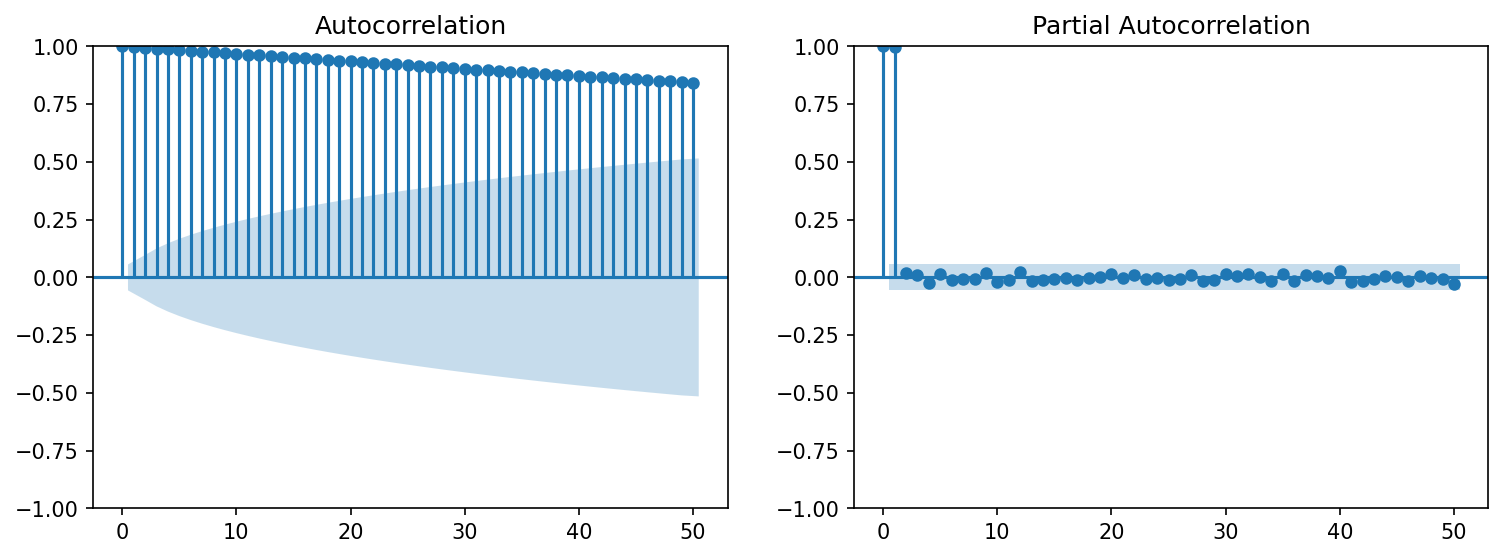

In [10]:
## 模型识别
# 绘制自相关图和偏自相关图并识别模型
fig = plt.figure(figsize=(12, 4), dpi=150)
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(data, lags=50, ax=ax1)
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_pacf(data, lags=50, ax=ax2)
plt.savefig(fname='相关图.png')

### 5.2 自动识别
相关图难以判断，使用auto_arima比较AIC自动识别模型

In [11]:
# 识别模型
series = pd.Series(data)
model = auto_arima(series, seasonal= False, trace=True)
print(f"自动识别的阶数：(p, d, q) = {model.order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10609.212, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10613.733, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10612.959, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10613.018, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10603.027, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10611.386, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.138 seconds
自动识别的阶数：(p, d, q) = (0, 1, 0)


结合自相关系数和偏自相关系数，以及AIC判断，最终确定最优模型：  
$$ARIMA(0,1,0)$$
均值模型为：随机游走模型

## 六、模型拟合与参数检验

In [12]:
## 拟合模型
mod = sm.tsa.statespace.SARIMAX(data, order=(0,1,0))
res = mod.fit() 
print(res.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.35346D+00    |proj g|=  7.69579D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0   7.696D-01  -4.353D+00
  F =  -4.3534593158091601     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.609e-06    2.7e-07    

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


虽然报错，但不影响结果，我不管  
模型的参数检验通过，因此均值模型为：
$$X_t=X_{t-1}+\epsilon_t$$

## 七、均值模型的整体效果检验
### 7.1 残差的纯随机性检验

In [14]:
# 计算残差序列
residuals = res.resid

# 输出残差序列
print("残差序列：", residuals)

# 检验残差序列为白噪声
LB = acorr_ljungbox(residuals, lags=range(1, 21), boxpierce=True, return_df=True)
print(LB)

残差序列： 0       2.657122
1       0.002258
2      -0.000513
3      -0.008185
4       0.002009
          ...   
1213   -0.000029
1214    0.003679
1215   -0.000508
1216    0.005502
1217    0.005235
Length: 1218, dtype: float64
     lb_stat  lb_pvalue   bp_stat  bp_pvalue
1   0.000564   0.981061  0.000562   0.981084
2   0.000716   0.999642  0.000714   0.999643
3   0.012914   0.999611  0.012863   0.999614
4   0.013299   0.999978  0.013245   0.999978
5   0.016537   0.999998  0.016465   0.999998
6   0.018202   1.000000  0.018119   1.000000
7   0.019074   1.000000  0.018984   1.000000
8   0.021507   1.000000  0.021397   1.000000
9   0.026077   1.000000  0.025926   1.000000
10  0.026080   1.000000  0.025930   1.000000
11  0.039022   1.000000  0.038733   1.000000
12  0.047087   1.000000  0.046706   1.000000
13  0.047838   1.000000  0.047447   1.000000
14  0.048513   1.000000  0.048113   1.000000
15  0.048544   1.000000  0.048144   1.000000
16  0.050782   1.000000  0.050349   1.000000
17  0.050810 

### 7.2残差的正态性检验
#### 判断标准化残差是否服从标准正态分布  
检验：$$E(\epsilon_t)=0$$
$$D(\epsilon_t)=1$$
$$\epsilon_t服从N(0,1)$$
#### 残差的自相关函数  
计算判断各个残差之间是否相关
#### LB检验  
原假设H0：这组数据为纯随机的，序列值之间相互独立。
$$
H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1
$$  
备择假设H1：这组数据非白噪声序列，至少存在一个自相关系数不为零。
$$
H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m
$$  
采用LB统计量作为检验统计量：
$$
LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)
$$

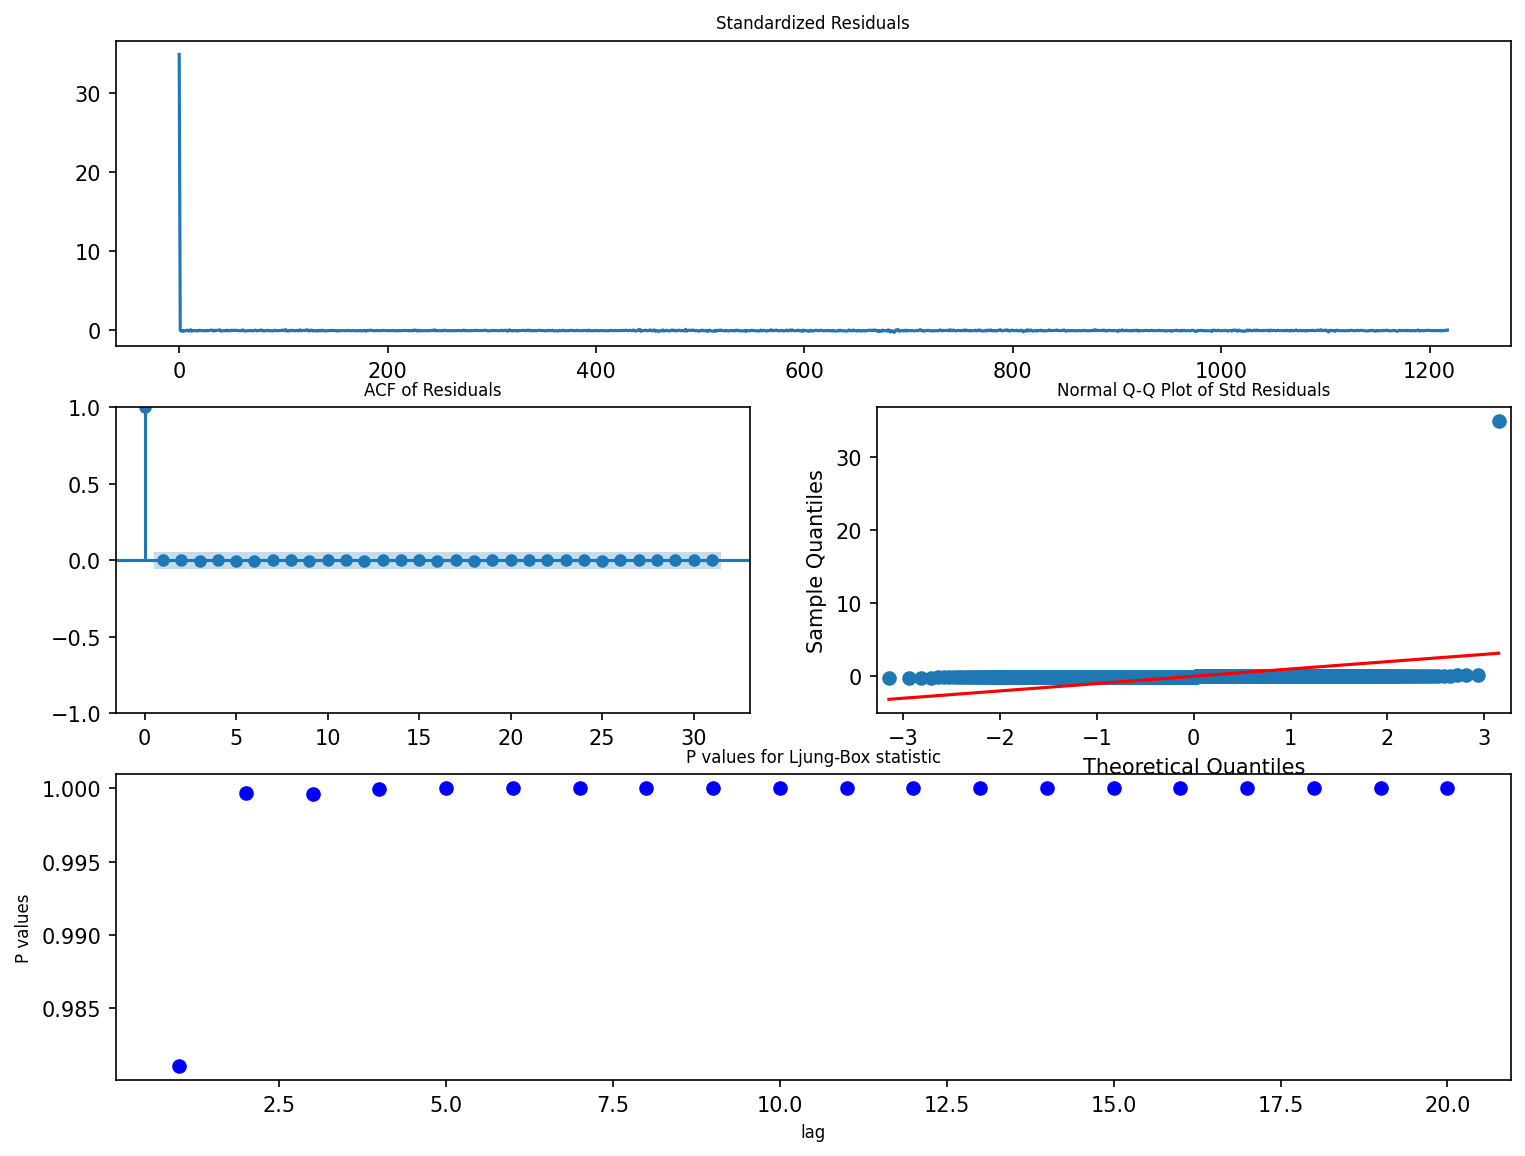

In [15]:
resid_sd = (residuals-np.mean(residuals))/np.std(residuals)
fig = plt.figure(figsize=(12,9),dpi=150)  
ax1 = fig.add_subplot(311)  
ax1.plot(resid_sd);plt.title('Standardized Residuals', fontsize=8)  

ax2 = fig.add_subplot(323)  
plot_acf(residuals, ax=ax2)
plt.title('ACF of Residuals', fontsize=8)  

ax3 = fig.add_subplot(324)  
sm.qqplot(resid_sd, fit=True, line="s",ax=ax3)  
plt.title('Normal Q-Q Plot of Std Residuals', fontsize=8)  

lags = np.arange(1,21)
LB_p = LB.lb_pvalue
ax4 = fig.add_subplot(313)  
ax4.scatter(lags,LB_p,color="blue")
plt.xlabel(xlabel="lag", fontsize=8)  
plt.ylabel(ylabel="P values", fontsize=8)  
plt.title('P values for Ljung-Box statistic', fontsize=8)   
plt.savefig(fname='整体效果检验.png')

结果表明残差中可能还有信息，需要进一步检验其自相关性与异方差性来修正残差模型

## 八、残差的自相关性检验
### 8.1 DW检验
原假设$$ H0：P = 0（残差项不存在一阶序列相关）$$
备择假设$$  H1：P ≠ 0（残差项存在一阶序列相关）$$
检验统计量：$$DW=\sum_{t = 2}^{n}\frac{(e_{t}-e_{t - 1})^{2}}{\sum_{t = 2}^{n}e_{t}^{2}}$$
判断$$DW < d_l：拒绝H0，存在正相关性$$
$$d_l < DW < d_u：无法做出确切判断$$
$$d_u < DW < 4 - d_u：接受H0，不存在自相关性$$
$$4 - d_u < DW < 4 - d_l：无法做出确切判断$$
$$DW > 4 - d_l：拒绝H0，存在负相关性$$
其中$d_l$为DW检验统计量的下临界值，$d_u$为DW检验统计量的上临界值。

In [16]:
## 残差的自相关检验
# DW检验
dw_stat = durbin_watson(residuals)
print("DW统计量:", dw_stat)
if dw_stat < 1:
    print("DW检验下可能存在正自相关")
elif dw_stat > 3:
    print("DW检验下可能存在负自相关")
else:
    print("DW检验下不存在一阶自相关")

DW统计量: 1.0000241443946285
DW检验下不存在一阶自相关


### 8.2 Durbin h检验
检验统计量$$Dh=DW\frac{n}{1-n\sigma^2_\beta}$$

In [17]:
# Durbin-h检验
# 首先获取滞后因变量系数估计量的方差
n = len(residuals)
var_beta_1 = np.var(residuals)  # 不知道这个方差写错了没
h = dw_stat * (n / (1 - n * var_beta_1))
print("Dh统计量:", h)
z_alpha_2 = 1.96
if np.abs(h) > z_alpha_2:
    print("Dh检验下拒绝原假设，残差存在自相关性")
else:
    print("Dh检验下不拒绝原假设，残差不存在自相关性")

Dh统计量: -200.84898688724056
Dh检验下拒绝原假设，残差存在自相关性


由于Durbin h检验统计量修正的DW检验统计量的缺陷，因此以Durbin h检验为准，认为残差存在自相关性

## 九、残差自相关的解决Auto-Regressive
即进一步对均值模型的残差$\epsilon_t$建模
$$\epsilon_t=\sum_{k = 1}^{m}\beta_k\epsilon_{t-k}+v_t$$

In [19]:
# 残差自相关性的解决 Auto-Regressive
rsd = pd.Series(residuals)
res = AutoReg(rsd, lags=4, trend='n').fit()
print(res.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1          -0.0202      0.029     -0.704      0.481      -0.076       0.036
y.L2          -0.0143      0.029     -0.498      0.618      -0.070       0.042
y.L3           0.0323      0.029      1.128      0.259      -0.024       0.089
y.L4           0.0006      0.001      0.519      0.603      -0.002       0.003


Auto-Regressive模型为：
$$\epsilon_t=0.0323\epsilon_{t-3}+0.0006\epsilon_{t-4}+v_t$$

## 十、残差的异方差性检验
### 10.1 White 检验
原假设$$H0：残差项的方差是常数，不存在异方差$$ 
备择假设$$H1：残差项的方差是不常数，存在异方差$$
采用LM统计量作为检验统计量：
$$
LM=nR^2\sim \chi^2_\alpha(q)
$$

In [20]:
## 异方差检验
# White 检验
vt = res.resid
data_for_white_test = data[:len(vt)]
exog = np.column_stack((np.ones(len(vt)), data_for_white_test))

white_test_results = het_white(vt, exog)
print(f"White 检验统计量：{white_test_results[0]}")
print(f"White 检验的p 值：{white_test_results[1]}")

if white_test_results[1] < 0.05:
    print('White检验下存在异方差性。')
else:
    print('White检验下不存在异方差性。')

White 检验统计量：6.782574156229902
White 检验的p 值：0.033665319107668984
White检验下存在异方差性。


### 10.2 Portmanteau Q检验
原假设
$$H0:\rho_1 = \rho_2 = \cdots = \rho_q = 0$$
备择假设
$$H1:\rho_1,\rho_2,\cdots,\rho_q不全为0$$
检验统计量
$$ Q(q) = n(n+2)\sum_{i=1}^{q}\frac{\rho^2_i}{n-i} \sim \chi^2(q-1)$$

In [21]:
# Portmanteau Q检验
Q = acorr_ljungbox(vt**2, lags=range(1, 31), boxpierce = True, return_df = True )
print(Q)
# p值小于0.05拒绝原假设，存在异方差性

       lb_stat     lb_pvalue     bp_stat     bp_pvalue
1    11.377213  7.435057e-04   11.349145  7.548273e-04
2    18.402491  1.009136e-04   18.351313  1.035292e-04
3    21.415155  8.631335e-05   21.351589  8.897928e-05
4    66.946585  1.000499e-13   66.658357  1.150761e-13
5    72.765397  2.720697e-14   72.443673  3.174924e-14
6    76.178421  2.194997e-14   75.834243  2.584291e-14
7    85.917698  8.504970e-16   85.501437  1.034937e-15
8    89.639227  5.504543e-16   89.192361  6.782571e-16
9    90.492035  1.296962e-15   90.037454  1.600140e-15
10   91.095927  3.246373e-15   90.635387  4.006829e-15
11   96.494624  8.806033e-16   95.976368  1.114355e-15
12   96.494721  2.697950e-15   95.976463  3.405151e-15
13   97.523394  5.000809e-15   96.992447  6.332596e-15
14   99.459096  6.020472e-15   98.902680  7.694056e-15
15  111.614228  7.894011e-17  110.887879  1.088807e-16
16  114.155368  7.243918e-17  113.391404  1.013549e-16
17  114.657889  1.594428e-16  113.886073  2.231654e-16
18  115.48

p值小于0.05拒绝原假设，认为残差序列存在异方差性

### 10.3 拉格朗日乘子(LM)检验
$$H0:\rho_1 = \rho_2 = \cdots = \rho_q = 0$$
备择假设
$$H1:\rho_1,\rho_2,\cdots,\rho_q不全为0$$
检验统计量
$$LM(q)=W^TW，W=(\frac{\rho^2_1}{\hat{\sigma}^2},\frac{\rho^2_2}{\hat{\sigma}^2},\cdots,\frac{\rho^2_q}{\hat{\sigma}^2})$$

In [22]:
# LM检验
for n in range(1, 31):
    alm = acorr_lm(vt, nlags = n)[0:2]
    print(alm)
# （T值，p值）p值小于0.05拒绝原假设，存在异方差性

(0.09735560858793613, 0.7550263855061643)
(0.3493014627180968, 0.8397502679900367)
(0.58759716259069, 0.8992657567653023)
(3.06381677925077, 0.5472031987452883)
(3.05497121199319, 0.6915110612142824)
(5.155919038116678, 0.5239766835371953)
(5.162598753237705, 0.6401280316309945)
(6.487732660914675, 0.5927686617953987)
(7.011263880919671, 0.6359466161945561)
(7.5359469121707905, 0.6740627009759349)
(7.661508891432376, 0.7432660811127214)
(7.9431534680866, 0.7895568247783795)
(8.259653705892136, 0.8262824139254445)
(11.25239545320329, 0.6661043661202093)
(11.968431248578428, 0.6814169892108507)
(12.269424443330399, 0.7252341795827003)
(12.420191062445284, 0.7740526787389931)
(13.596698145717113, 0.7549780696038377)
(15.808711385061333, 0.6700004091346518)
(19.137262964410535, 0.5129205443503422)
(20.21359496191725, 0.5077702966412574)
(20.75981821376935, 0.5356212828687821)
(23.869113707210598, 0.4110856126871774)
(23.84542007309271, 0.4704646754452625)
(24.796773622662332, 0.47380827713

综合上述检验，在White检验、Portmanteau Q检验下检验通过，LM检验未通过，认为残差可能存在异方差性，进一步修正

## 十一、残差异方差性的解决GRACH模型
进一步对残差的$v_t$建模
$$\begin{cases}
v_t = \sqrt{h_t}e_t  \\ 
h_t = \omega + \sum_{i=1}^{p}y_ih_{t-i} + \sum_{j=1}^{1}\lambda_jv_{t-j}^2
\end{cases}$$

In [23]:
## 残差异方差性的解决 GARCH 模型
vt_model = arch_model(vt, mean='Zero', vol="GARCH").fit(disp="off")  
print(vt_model.summary().tables[1])  

                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.9125e-07  5.164e-11   3703.849      0.000 [1.911e-07,1.914e-07]
alpha[1]       0.0500  1.644e-02      3.042  2.350e-03 [1.778e-02,8.222e-02]
beta[1]        0.9300  1.468e-02     63.337      0.000     [  0.901,  0.959]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.459e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


GARCH模型为：
$$GARCH(1,1)$$
具体而言是：
$$\begin{cases}
v_t = \sqrt{h_t}e_t  \\ 
h_t = 1.9125e-07 + 0.0500h_{t-1} + 0.9300v_{t-1}^2
\end{cases}$$

## 十二、残差模型的整体效果检验
### 12.1 残差的方差纯随机性检验
残差模型已经建好，进一步判断其方差是否为白噪声数据，来判断残差模型的整体效果，采用LB检验。  
原假设：$$H_0: \rho_1=\rho_2=\cdots=\rho_m=0, \forall m \geq 1$$  
备择假设：$$H_1: \rho_k \neq 0,  \forall m \geq 1, k \leq m$$  
LB统计量：$$LB=n(n+2) \sum_{k=1}^m\left(\frac{\hat{\rho}_k^2}{n-k}\right) \sim \chi^2(m)$$

In [24]:
## GARCH模型的检验
# 纯随机检验
h_t = vt_model.conditional_volatility  
e_t = vt/(np.sqrt(h_t))  
LB = acorr_ljungbox(e_t, lags=range(1, 31), boxpierce=True, return_df=True)  
print(LB)

      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    0.043477   0.834830   0.043369   0.835031
2    0.148220   0.928569   0.147768   0.928779
3    0.200035   0.977584   0.199370   0.977691
4    3.146236   0.533658   3.131034   0.536142
5    3.270595   0.658347   3.254677   0.660787
6    4.624685   0.592769   4.599858   0.596058
7    4.627247   0.705345   4.602401   0.708354
8    5.365695   0.717870   5.334776   0.721268
9    5.741933   0.765443   5.707611   0.768787
10   6.410987   0.779634   6.370063   0.783273
11   6.426128   0.843474   6.385042   0.846478
12   6.792392   0.871023   6.747090   0.873864
13   6.886716   0.907895   6.840250   0.910195
14   9.952156   0.765673   9.865355   0.771960
15  10.444489   0.790889  10.350805   0.797112
16  10.616936   0.832490  10.520700   0.838060
17  10.667993   0.873294  10.570959   0.877979
18  12.259134   0.833574  12.135930   0.840141
19  13.551562   0.809178  13.406037   0.817152
20  16.551319   0.681887  16.351522   0.694591
21  16.944030

从结果上来看，p值大于0.05，不拒绝原假设，认为这一组序列为白噪声序列，具有纯随机性，残差模型的整体效果较好

### 12.2正态性检验
#### 图检验
包括Q-Q图、直方图检验  
#### JB检验  
原假设$$H0:\frac{\epsilon_t}{\sqrt{h_t}}\sim N(0,1)$$
备择假设$$H1:\frac{\epsilon_t}{\sqrt{h_t}}不服从N(0,1)$$
检验统计量$$JB=\frac{T}{6}b^2_1+\frac{T}{24}(b^2_2-3)^2\sim\chi^{2}(2)$$

Jarque-Bera统计量: 247.8922676385989
p值: 1.4821017805934663e-54
拒绝原假设，残差不服从正态分布。


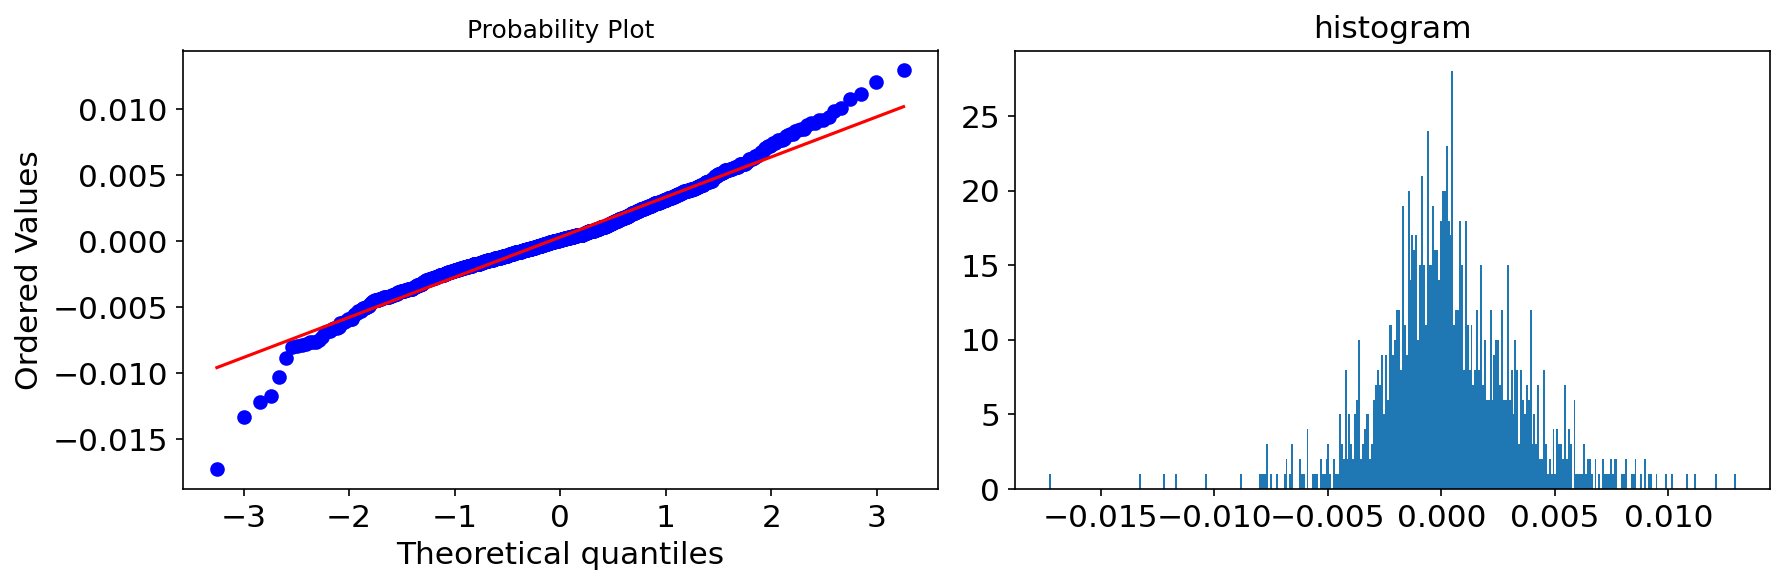

In [25]:
# 正态性检验
# 绘制 QQ 图
fig = plt.figure(figsize=(12, 4), dpi=150)
ax1 = fig.add_subplot(121)
res1 = st.probplot(vt, plot=ax1)
ax1.set_ylabel(ylabel="Ordered Values", fontsize=15)
ax1.set_xlabel(xlabel="Theoretical quantiles", fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)

# 绘制直方图
ax2 = fig.add_subplot(122)
ax2.hist(vt, bins=360)
ax2.set_title('histogram', fontsize=15)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.tight_layout()
plt.savefig(fname='残差的正态性检验.png')

# JB检验
def self_JBtest(y):
    # 计算Jarque-Bera统计量和p值
    JB, pvalue= jarque_bera(y)
    return np.array([JB, pvalue])

# 对残差进行JB检验
jb_results = self_JBtest(vt)
print(f"Jarque-Bera统计量: {jb_results[0]}")
print(f"p值: {jb_results[1]}")
if jb_results[1] < 0.05:
    print("拒绝原假设，残差不服从正态分布。")
else:
    print("不能拒绝原假设，残差在JB检验下服从正态分布。")


虽然JB检验没通过，但看图感觉只是左偏了，问题不大，模型的整体提取信息没有问题。  
最终模型为：
$$ARIMA(0,1,0)-AR(4)-GARCH(1,1)$$
具体而言是：
$$\begin{cases}
X_t=X_{t-1}+\epsilon_t \\
\epsilon_t=0.0323\epsilon_{t-3}+0.0006\epsilon_{t-4}+v_t \\
v_t = \sqrt{h_t}e_t  \\ 
h_t = 1.9125e-07 + 0.0500h_{t-1} + 0.9300v_{t-1}^2
\end{cases}$$

## 十三、模型的预测

 This problem is unconstrained.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.35346D+00    |proj g|=  7.69579D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0   7.696D-01  -4.353D+00
  F =  -4.3534593158091601     

ABNORMAL_TERMINATION_IN_LNSRCH                              
未来30个数据的均值预测值：1218    10428.0
1219    10428.0
1220    10428.0
1221    10428.0
1222    10428.0
1223    10428.0
1224    10428.0
1225    10428.0
1226    10428.0
1227    10428.0
1228    10428.0
1229

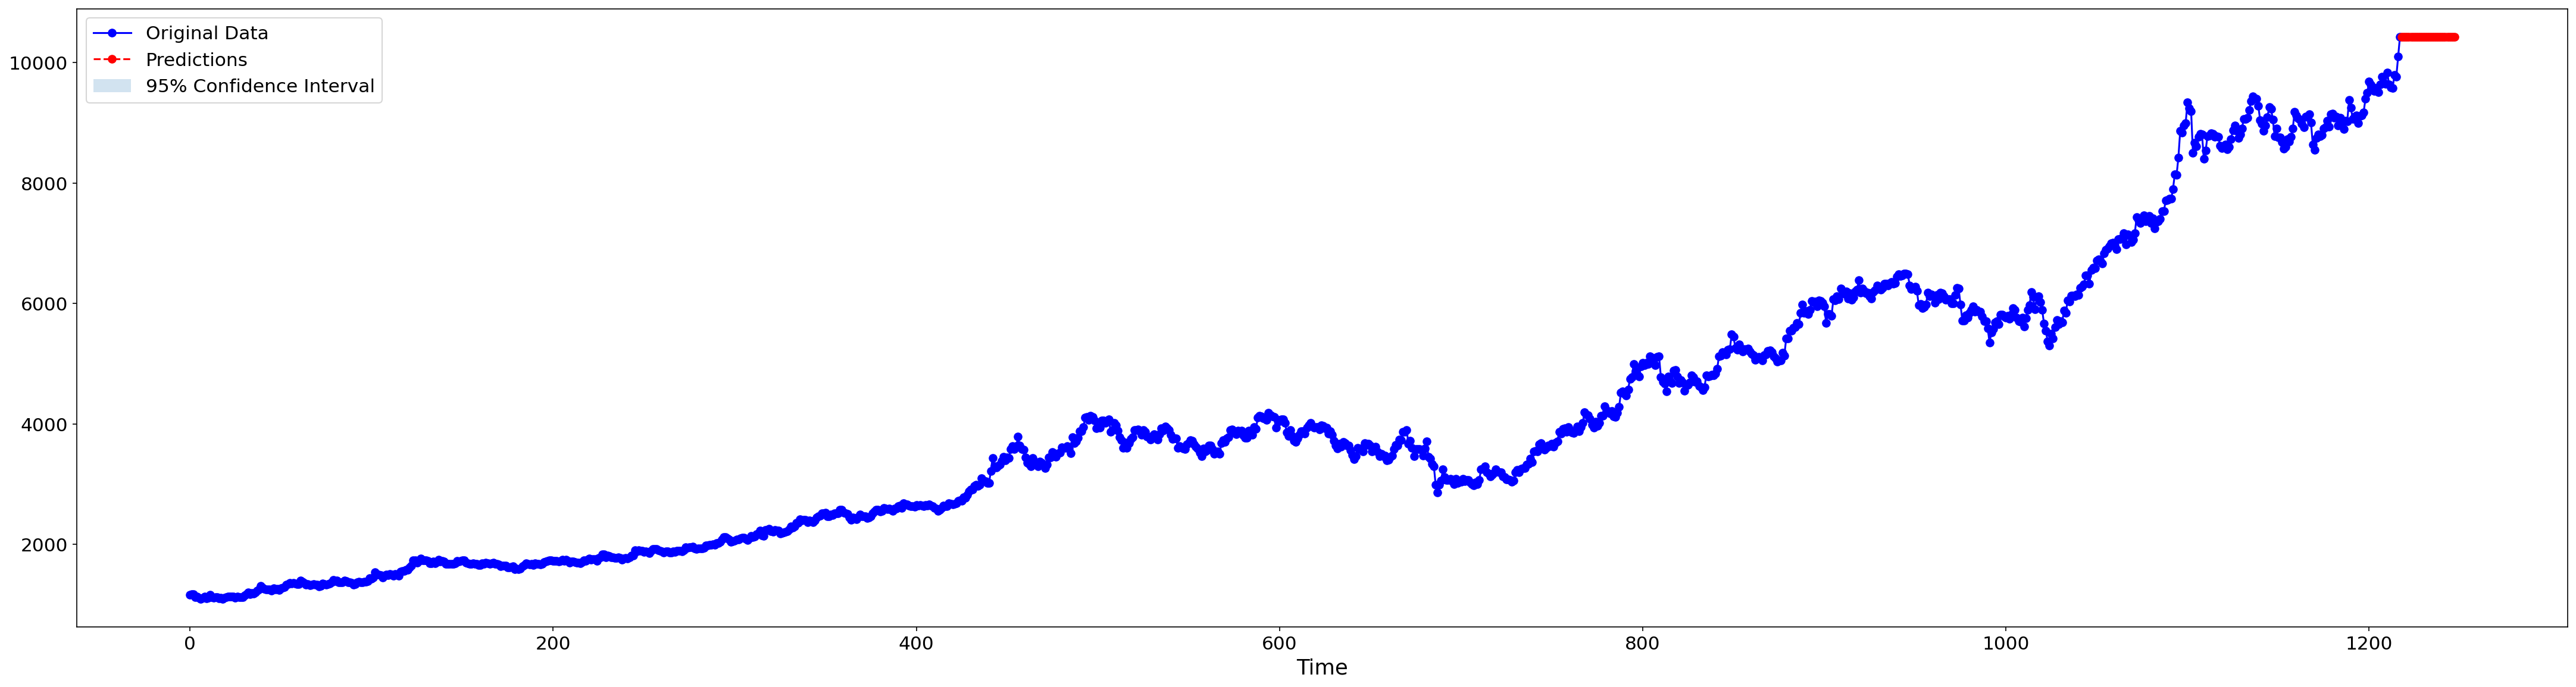

In [26]:
## 模型的预测
# 预测未来30个数据
last_index = len(data) - 1
forecast_index = np.arange(last_index + 1, last_index + 31)
# 基于ARIMA(0, 1, 0)模型进行预测
mod = sm.tsa.statespace.SARIMAX(data, order=(0,1,0))
res = mod.fit() 
arima_forecast = res.predict(start=last_index + 1, end=last_index + 30)
arima_mean_forecast = arima_forecast
# 还原数据
mean_forecast = np.exp(np.square(arima_mean_forecast))
print(f"未来30个数据的均值预测值：{mean_forecast}")

# 计算置信区间
var_original = np.var(h_t)
var = np.exp(np.square(var_original))
lower = [value - 2 * var for value in mean_forecast]
upper = [value + 2 * var for value in mean_forecast]
print(f"95%置信区间下区间下限：{lower}")
print(f"95%置信区间下区间上限：{upper}")

# 绘图
plt.figure(figsize=(36, 9), dpi=150)
plt.plot(range(len(data)), price, linestyle='-', color='b', marker='o', markerfacecolor='b', label='Original Data')
plt.plot(range(len(data), len(data) + len(mean_forecast)), mean_forecast, linestyle='--', color='r', marker='o', markerfacecolor='r', label='Predictions')
plt.fill_between(range(len(data), len(data) + len(mean_forecast)), lower, upper, alpha=0.2, label='95% Confidence Interval')
last_data_index = len(data) - 1
last_pred_index = len(data)
plt.plot([last_data_index, last_pred_index], [price[last_data_index], mean_forecast[last_data_index + 1]], linestyle='--', color='r')
plt.xlabel('Time', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig(fname='预测结果.png')

怀疑预测算错了，怎么置信区间这么小